In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader_02 import PuljaDataLoader
from models._20220720_00 import UserModel
from models.utils_02 import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 1000

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_c3, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220720_00"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (R): Embedding(2, 20)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=60, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [4]:
aucs_list = []
max_aucs = []
fin_aucs = []

dir_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_20220720_00", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)
    fin_auc = aucs[-1]

    aucs_list.append(aucs)
    max_aucs.append(max_auc)
    fin_aucs.append(fin_auc)

In [5]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.776448975550712, 0.7803050300330661, 0.7805041979047894, 0.7802277080773895, 0.768438815113542, 0.7774109881031346, 0.7799720950540692, 0.7804093055944845, 0.7806016281552073, 0.7741514765992781]
max_auc_mean: 0.7778470220185671, max_auc_std: 0.0037650393532267915
max_auc_dir: 09


In [6]:
print("max_fin_aucs: {}".format(fin_aucs))
print("max_fin_auc_mean: {}, max_auc_std: {}".format(np.mean(fin_aucs), np.std(fin_aucs)))
print("max_fin_auc_dir: {}".format(dir_list[np.argmax(fin_aucs)]))

max_fin_aucs: [0.7761251201376872, 0.7801010992627424, 0.780032435432433, 0.7800787040329541, 0.7680688119542867, 0.7769097650732029, 0.7794386813991147, 0.7796009918108823, 0.7804753602116377, 0.7738701680943741]
max_fin_auc_mean: 0.7774701137409316, max_auc_std: 0.0037577494496815185
max_fin_auc_dir: 09


In [7]:
test_dataset[3]

(array([29, 29, 29, ..., 76, 76, 76]),
 array([2, 2, 3, ..., 4, 4, 4]),
 array([1, 1, 0, ..., 0, 0, 0]))

In [8]:
# 3, 6
c3_seq, d_seq, r_seq = test_dataset[3]

view_from = 600
view_to = 1000

seq_len = view_to - view_from

c3_seq = [c3_seq[view_from:view_to]]
d_seq = [d_seq[view_from:view_to]]
r_seq = [r_seq[view_from:view_to]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

# c_seq = np.array([[0] * 100])
# d_seq = np.array([[6] * 30 + [3] * 30 + [0] * 40])
# r_seq = np.ones_like(r_seq)

# c1_seq, c2_seq, c4_seq, d_seq, r_seq: [batch_size, seq_len]

alpha_seq, h_seq, C3_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

# C3_seq: [batch_size, seq_len, num_c4]

# beta3_seq: [batch_size, seq_len]
beta3_seq = torch.gather(C3_seq, dim=-1, index=LongTensor(c3_seq).unsqueeze(-1)).reshape([1, seq_len])

# gamma_seq: [seq_len]
gamma_seq = model.D(LongTensor(d_seq)).squeeze()

###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta3_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta3_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ3_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()
CQ3_seq = torch.sigmoid(CQ3_seq).detach().cpu().numpy()[0]

# C3_seq = C3_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

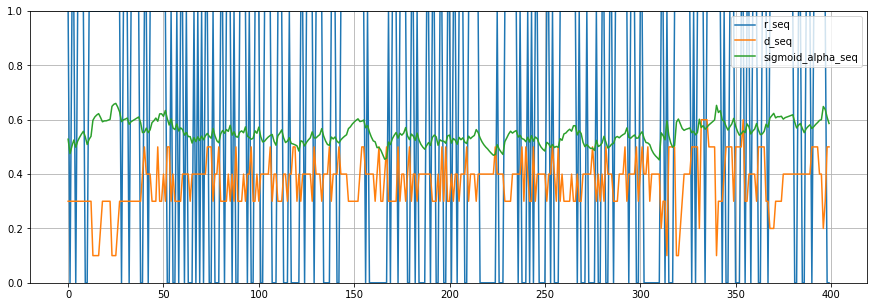

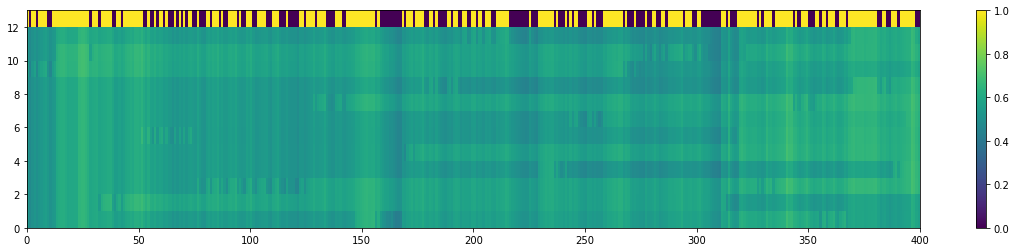

In [30]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
# plt.plot(sigmoid_alpha_beta4_seq, label="sigmoid_alpha_beta4_seq")
# plt.plot(sigmoid_beta4_seq, label="sigmoid_beta4_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure(figsize=[20, len(np.unique(c3_seq)) // 3], facecolor="white")
temp = np.concatenate([CQ3_seq[:, np.unique(c3_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

In [10]:
CQ3_seq[0][np.unique(c3_seq)]

array([0.5283227, 0.5283227, 0.5283227, 0.5283227, 0.5283227, 0.5283227,
       0.5283227, 0.5283227, 0.5283227, 0.5658479, 0.5283227, 0.5283227],
      dtype=float32)

In [11]:
CQ3_seq[-1][np.unique(c3_seq)]

array([0.563029  , 0.56245494, 0.6427938 , 0.6420863 , 0.6323215 ,
       0.628812  , 0.6333972 , 0.6414841 , 0.6216944 , 0.57879794,
       0.61602765, 0.58459383], dtype=float32)

In [12]:
np.unique(c3_seq), c3_seq

(array([ 8, 26, 27, 29, 40, 42, 50, 55, 71, 73, 75, 76]),
 [array([73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 27, 27, 55, 55, 55, 55, 55, 55, 55, 55,
         55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 40,
         40, 40, 40, 40, 40, 40, 40, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71,
         71, 71, 71, 71, 71, 71, 71, 71, 76, 76, 76, 76, 76, 76, 76, 76, 76,
         76, 76, 7

In [13]:
dataset.c3_list[np.unique(c3_seq)]

array(['01 명제와 조건', '01 집합의 뜻과 표현', '01 집합의 연산', '01 함수', '02 명제의 역, 대우',
       '02 부분집합', '02 여러 가지 함수', '02 원소의 개수', '03 충분조건과 필요조건', '03 합성함수',
       '04 역함수', '04 절대부등식'], dtype=object)

In [14]:
dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]

'01 집합의 뜻과 표현'

In [15]:
dataset.c32c4_list[dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]]

['[1] 집합의 뜻',
 '[2] 집합과 원소 사이의 관계',
 '[3] 집합의 표현 방법',
 '[4] 유한집합과 무한집합',
 '[5] 유한집합의 원소의 개수',
 '[6] 기호 ∈, ⊂의 사용',
 '[7] 집합 사이의 포함 관계',
 '[8] 집합 사이의 포함 관계가 성립하도록 하는 미지수 구하기']

In [16]:
d_seq

[array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 2,
        2, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 3, 3, 3,
        2, 2, 2, 4, 2, 2, 3, 2, 4, 4, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 2, 3, 3, 4, 2, 2, 2, 2, 3, 2, 3, 2,
        4, 2, 2, 2, 3, 2, 3, 3, 4, 2, 2, 3, 2, 3, 3, 3, 3, 3, 4, 2, 3, 3,
        2, 2, 2, 3, 3, 2, 3, 3, 4, 4, 2, 3, 2, 3, 3, 3, 3, 3, 2, 4, 3, 3,
        3, 2, 3, 3, 3, 4, 2, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3,
        4, 4, 3, 3, 3, 3, 3, 2, 3, 4, 2, 2, 3, 4, 2, 2, 2, 2, 2, 4, 2, 3,
        3, 2, 3, 4, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 4, 2,
        4, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 4, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 2, 4, 3,
        2, 2, 4, 2, 3, 3, 3, 3, 3, 2, 3, 3, 4, 3, 2, 4, 2, 3, 2, 2, 2, 2,
        3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 4, 3, 2, 3, 2, 3, 2, 4, 3, 3, 3,
        2, 2, 2, 3, 3, 3, 4, 2, 3, 3, 

In [17]:
model.D.weight

Parameter containing:
tensor([[-0.7314],
        [-0.5066],
        [-0.2137],
        [ 0.2518],
        [ 0.6056],
        [ 0.8486],
        [ 1.1526]], requires_grad=True)

In [18]:
h_seq.shape

torch.Size([1, 400, 20])

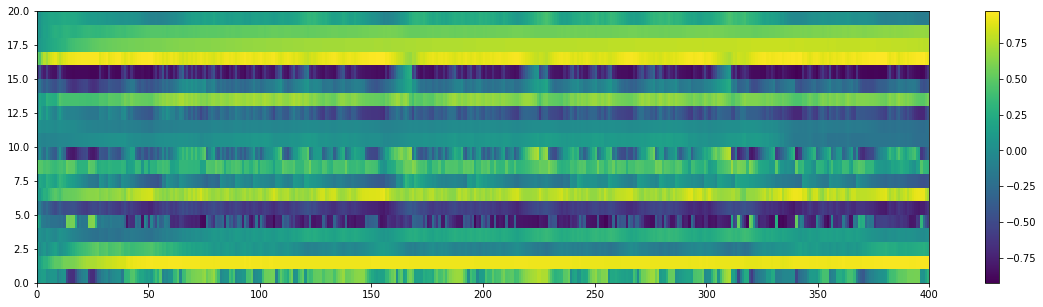

In [19]:
plt.figure(figsize=[20, 5], facecolor="white")
plt.pcolormesh(h_seq[0].detach().cpu().numpy().T)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [20]:
dataset.c22c3_list

{'01 다항식의 연산': ['01 다항식의 연산', '02 다항식의 곱셈공식', '03 다항식의 나눗셈'],
 '01 삼각비': ['소단원'],
 '01 제곱근과 실수': ['소단원'],
 '01 지수': ['01 거듭제곱과 거듭제곱근', '02 지수의 확장'],
 '01 집합의 뜻과 표현': ['01 집합의 뜻과 표현', '02 부분집합'],
 '01 함수의 극한': ['01 함수의 극한', '02 함수의 극한에 대한 성질', '03 함수의 극한의 응용'],
 '02 로그': ['01 로그의 뜻과 성질', '02 상용로그'],
 '02 삼각형의 외심과 내심': ['소단원'],
 '02 집합의 연산': ['01 집합의 연산', '02 원소의 개수'],
 '02 함수의 연속': ['01 함수의 연속', '02 연속함수의 성질'],
 '02 항등식과 나머지정리': ['01 항등식', '02 나머지정리와 인수정리'],
 '03 명제': ['01 명제와 조건', '02 명제의 역, 대우', '03 충분조건과 필요조건', '04 절대부등식'],
 '03 미분계수와 도함수': ['01 미분계수', '02 도함수'],
 '03 원과 직선': ['소단원'],
 '03 인수분해': ['01 인수분해'],
 '03 지수함수': ['01 지수함수의 뜻과 그래프', '02 지수함수의 최대 · 최소', '03 지수함수의 활용'],
 '04 도함수의 활용(1)': ['01 접선의 방정식', '02 평균값 정리'],
 '04 로그함수': ['01 로그함수의 뜻과 그래프', '02 로그함수의 최대 · 최소', '03 로그함수의 활용'],
 '04 복소수': ['01 복소수의 성질과 연산', '02 i의 거듭제곱, 음수의 제곱근'],
 '04 원주각': ['소단원'],
 '04 함수': ['01 함수', '02 여러 가지 함수', '03 합성함수', '04 역함수'],
 '05 대푯값과 산포도': ['소단원'],
 '05 도함수의 활용(2)': ['01 함수의 증가와 감소', '02 함수

In [21]:
c2 = "01 집합의 뜻과 표현"

CQ2_seq = []
CQ2_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()[:, [dataset.c32idx[c3] for c3 in dataset.c22c3_list[c2]]].mean(-1, keepdims=True)
CQ2_seq = torch.sigmoid(CQ2_seq).detach().cpu().numpy()[0]

CQ2_seq[0], CQ2_seq[-1]

(array([0.5283227], dtype=float32), array([0.5960727], dtype=float32))

In [22]:
c2 = "04 함수"

CQ2_seq = []
CQ2_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()[:, [dataset.c32idx[c3] for c3 in dataset.c22c3_list[c2]]].mean(-1, keepdims=True)
CQ2_seq = torch.sigmoid(CQ2_seq).detach().cpu().numpy()[0]

CQ2_seq[0], CQ2_seq[-1]

(array([0.53775096], dtype=float32), array([0.61785483], dtype=float32))

In [23]:
c2 = "05 유리함수"

CQ2_seq = []
CQ2_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()[:, [dataset.c32idx[c3] for c3 in dataset.c22c3_list[c2]]].mean(-1, keepdims=True)
CQ2_seq = torch.sigmoid(CQ2_seq).detach().cpu().numpy()[0]

CQ2_seq[0], CQ2_seq[-1]

(array([0.5283227], dtype=float32), array([0.586208], dtype=float32))

In [24]:
dataset.num_c3

78

In [25]:
C3_seq.shape

torch.Size([1, 400, 78])

In [26]:
model.eval()
alpha_seq, h_seq, C3_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

model.eval()
alpha_seq_0, h_seq_0, C3_seq_0 = model(
    LongTensor(c3_seq)[:, :50],
    LongTensor(d_seq)[:, :50],
    LongTensor(r_seq)[:, :50],
)

alpha_seq_1, h_seq_1, C3_seq_1 = model(
    LongTensor(c3_seq)[:, 50:],
    LongTensor(d_seq)[:, 50:],
    LongTensor(r_seq)[:, 50:],
    h_seq_0[:, -1, :],
    C3_seq_0[:, -1, :],
)

alpha_seq_2 = torch.cat([alpha_seq_0, alpha_seq_1], dim=-1)
h_seq_2 = torch.cat([h_seq_0, h_seq_1], dim=1)
C3_seq_2 = torch.cat([C3_seq_0, C3_seq_1], dim=1)

In [27]:
(alpha_seq - alpha_seq_2).max(), (h_seq - h_seq_2).max(), (C3_seq - C3_seq_2).max()

(tensor(5.9605e-08, grad_fn=<MaxBackward1>),
 tensor(2.0862e-07, grad_fn=<MaxBackward1>),
 tensor(0., grad_fn=<MaxBackward1>))

In [28]:
print(np.random.normal(size=[20]))

[-0.13235668  0.25884188 -1.30191934 -1.19014593 -0.42631276  1.587945
 -0.24046722  0.25753696  0.24656014  0.6632001  -0.92659349  1.7620196
  1.36088267 -1.13916028 -0.64878002 -0.94645537  1.54330728 -0.89362387
 -0.45099141  0.10824645]


In [29]:
np.random.normal(size=[dataset.num_c3])

array([-0.53613985, -0.35052787, -1.22067343,  0.17945383, -0.15210356,
        0.04887339, -0.01633131,  0.06413793,  1.08722173,  0.55431748,
        1.15124011,  0.04098418,  0.23344845, -0.07518995,  1.31994019,
        0.3200598 , -0.12484861,  1.29631467, -0.28391863, -0.00292568,
        2.30915005,  1.61885093, -0.20212787,  0.01526445,  1.50576411,
       -0.85081365, -1.01601045, -0.89225217, -0.96452574,  0.02515669,
        1.02558091,  0.13177518,  0.84326791, -0.14769302,  0.40255509,
        1.02977079, -2.25895857, -0.51599536,  1.235224  ,  0.25203156,
       -0.18370995, -0.62456127,  1.3636647 ,  2.27932083, -0.0415129 ,
        0.62958441,  1.11505914, -1.26642762,  1.22091871,  1.45685481,
        0.06500442, -0.63987133,  0.41100632, -0.21978279, -0.44514194,
       -0.07643019, -1.75986232, -0.17611746,  0.3779949 ,  0.5595493 ,
       -0.93830621, -0.72318461,  0.07786278, -1.01696441, -1.31923309,
        0.58915407,  1.82973867,  1.66971003, -1.91461261, -1.37